# Simple Linear Regression
Haytham Mohamed

INFS 890 - Spring 2020

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest
import seaborn as sns
from sklearn import preprocessing, metrics, feature_selection
from datetime import datetime
from scipy import stats
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.4f}'.format

Set this flag to True if you're using reduction feature using FCA, otherwise set it to False

In [2]:
# 1- read data file
# 1- read processed file
home_dir = '/Users/hmohamed/github/data-research-spring2020/sock-shop'
file_dir = home_dir + '/processed-data/'

data_file = 'orders_flow_data.csv'   # raw data as is
#data_file = 'order_flow_cleanup_data.csv'
#data_file = 'order_flow_normalized_data.csv'
#data_file = 'order_flow_standardized_data.csv'
#data_file = 'order_flow_factored_data.csv'


SCALE_TARGETS = True

test_split = 0.1

In [3]:
def read_df(file_dir, data_file, timeseries=True):
    df = pd.read_csv(file_dir + data_file)
    if timeseries:
        df = to_time_series(df)
    return df

def to_time_series(df, index_col_name='date'):
    df[index_col_name] = pd.to_datetime(df[index_col_name])
    df.set_index(index_col_name, inplace=True)
    df.sort_index(inplace=True)
    return df

def merge(df, series):
    return pd.merge_asof(df, series, left_index=True, right_index=True, tolerance=pd.Timedelta('1 second')).bfill()    


In [4]:
data = read_df(file_dir, data_file, True)
data = data.reset_index(drop=True)

print('data shape {}'.format(data.shape))

data.head(5)

data shape (6766, 29)


,front-end_cpu_use,orders_cpu_use,orders-db_cpu_use,user_cpu_use,user-db_cpu_use,shipping_cpu_use,payment_cpu_use,carts_cpu_use,carts-db_cpu_use,front-end_pods,...,user-db_net_use,shipping_net_use,payment_net_use,carts_net_use,carts-db_net_use,nodes_cpu_use,nodes_disk_io,nodes_net_use,orders_req,orders_ltcy
0,0.0300,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0300,0.0700,1.0000,...,2.2044,2.6585,8.9654,22.0117,4.7995,2.5000,1.6700,2.7617,0.1500,0.2400
1,0.0600,0.0200,0.0200,0.0200,0.0200,0.0100,0.0100,0.1800,0.1800,1.0000,...,2.2044,2.6585,8.9654,22.0117,4.7995,1.8900,1.0100,2.7617,0.1500,0.2400
2,0.0700,0.0300,0.0200,0.0300,0.0200,0.0100,0.0100,0.4400,0.2000,1.0000,...,16.0739,13.5708,16.9964,27.3438,16.6522,1.3500,0.0500,2.5880,0.1500,0.2400
3,0.0700,0.0300,0.0200,0.0200,0.0200,0.0100,0.0100,0.2300,0.1700,1.0000,...,19.9869,14.4342,9.5804,9.4313,17.1768,1.2600,0.0400,2.1487,0.1300,0.2400
4,0.0700,0.0200,0.0100,0.0200,0.0200,0.0100,0.0100,0.2400,0.1400,1.0000,...,10.4490,3.7392,2.7970,9.1791,6.2516,1.2800,0.2600,1.8080,0.3600,0.2400


In [5]:
targets = data['orders_ltcy']
inputs = data.drop(['orders_ltcy'], axis=1)

n_features = inputs.values.shape[1]
print("there are {} features".format(n_features))

# scale targets for better convergence
if SCALE_TARGETS:
    y_scaler =  MinMaxScaler()
    targets = y_scaler.fit_transform(targets.values.reshape(-1,1))
    
x_train, x_test, y_train, y_test = \
    train_test_split(inputs, targets, test_size=test_split, shuffle=False, random_state=365)  


there are 28 features


In [7]:
# print out the features
for feature in inputs.columns.values:
    print(feature)

front-end_cpu_use
orders_cpu_use
orders-db_cpu_use
user_cpu_use
user-db_cpu_use
shipping_cpu_use
payment_cpu_use
carts_cpu_use
carts-db_cpu_use
front-end_pods
orders_pods
user_pods
shipping_pods
payment_pods
carts_pods
front-end_net_use
orders_net_use
orders-db_net_use
user_net_use
user-db_net_use
shipping_net_use
payment_net_use
carts_net_use
carts-db_net_use
nodes_cpu_use
nodes_disk_io
nodes_net_use
orders_req


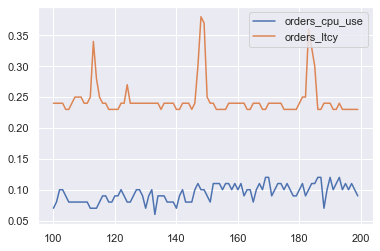

In [549]:
# plot cpu vs latency 
plt.plot(data['orders_cpu_use'][100:200], label='orders_cpu_use')
plt.plot(data['orders_ltcy'][100:200], label='orders_ltcy')
plt.legend()
plt.show()


# Model

In [550]:
lasso = LassoCV(tol=0.1)
sfm = SelectFromModel(lasso, threshold='0.02*mean')

reg = LinearRegression(normalize=True) # normalize false bacause we are going to use the scaler

pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('selector', sfm),
    ('reg', reg)
])

kfold = KFold(n_splits=10, shuffle=True)

param_grid = {
    'selector__threshold': ['1*mean','0.7*mean','0.5*mean','0.1*mean', '0.05*mean']
     ,'reg__normalize': [False, True]
}

search = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error'
                      , return_train_score= True, cv=kfold, verbose=1, n_jobs=-1, refit=True)



In [551]:
import sklearn 
print('sklearn version {}'.format(sklearn.__version__))

search.fit(x_train, y_train)

sklearn version 0.22.2.post1
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
/opt/anaconda3/envs/infs890/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('selector',
                                        SelectFromModel(estimator=LassoCV(alphas=None,
                                                                          copy_X=True,
                                                                          cv=None,
                                                                          eps=0.001,
                                                                          fit_intercept=True,
                                                                          max_iter=1000,
                    

# Best Parameters

Best CV test score = -0.0646:
Best CV params = {'reg__normalize': False, 'selector__threshold': '0.05*mean'}


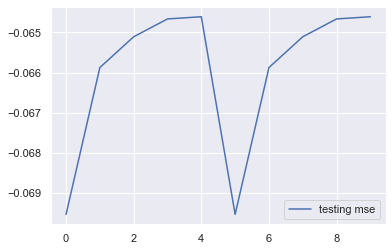

In [552]:
score = search.best_score_
print("Best CV test score = %0.4f:" % score)

params = search.best_params_
print("Best CV params = {}".format(params))

all_training_scores = search.cv_results_

pdf = pd.DataFrame(all_training_scores['mean_test_score'], columns=['testing mse'])
pdf.plot()


# Features Selected

In [553]:
if 1 == 1:
    best_threshold = params['selector__threshold']
    
    print('best selector threshold {}'.format(best_threshold))

    rfr = LassoCV(tol=0.1)
    sfm = SelectFromModel(rfr)

    selectedFeatures = sfm.fit(x_train, y_train).transform(x_train)
    print('{} features selected'.format(selectedFeatures[1].shape[0]))

    feature_list = x_train.columns[sfm.get_support()]
    features = ''
    features = ', '.join(feature_list)
    #features

    reduced_x_train = x_train[feature_list]
    #reduced_x_train.head(2)
    print('')
    for feature in reduced_x_train.columns.values:
        print(feature)

best selector threshold 0.05*mean
14 features selected

carts_cpu_use
carts-db_cpu_use
front-end_pods
front-end_net_use
orders_net_use
user_net_use
user-db_net_use
shipping_net_use
payment_net_use
carts_net_use
carts-db_net_use
nodes_cpu_use
nodes_net_use
orders_req


/opt/anaconda3/envs/infs890/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Training R2

In [554]:
y_train_pred = search.predict(x_train)

r2_train = metrics.r2_score(y_train, y_train_pred)
print('R2 (training) = {}'.format(r2_train))

print('Score (training) = {}'.format(search.score(x_train,y_train)))

R2 (training) = 0.4721979410526367
Score (training) = -0.06423088745765093


In [555]:
estimator = search.best_estimator_

estimator.named_steps.reg.intercept_

array([0.28114655])

In [556]:
estimator.named_steps.reg.coef_

array([[-0.19349626, -0.05999852,  0.03088422,  0.2675089 , -0.04283994,
        -0.00229339,  0.30261019,  0.13762804, -0.01019788, -0.0627606 ,
        -0.06350105,  0.03835219,  0.1744495 ,  0.05260351, -0.0587444 ,
         0.00429468, -0.08805117, -0.10943627]])

In [557]:
# validation mean_absolute_percentage_error
train_error =  np.abs(y_train - y_train_pred)
mean_error = np.mean(train_error)
min_error = np.min(train_error)
max_error = np.max(train_error)
std_error = np.std(train_error)

print("Model Result (mean - std of error - min - max): %.2f (%.2f) %.2f %.2f MSE" \
      % (mean_error, std_error, min_error, max_error))

Model Result (mean - std of error - min - max): 0.19 (0.16) 0.00 1.04 MSE


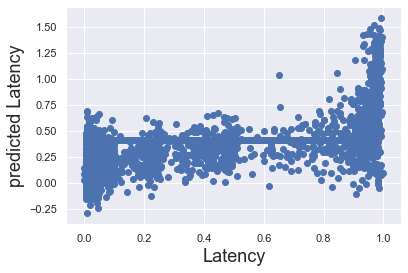

In [558]:
plt.scatter(y_train, y_train_pred)
plt.xlabel('Latency', size=18)
plt.ylabel("predicted Latency", size=18)
plt.show()

Text(0.5, 1.0, 'Residual PDF')

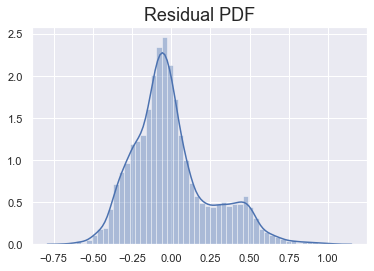

In [559]:
sns.distplot(y_train - y_train_pred)
plt.title('Residual PDF', size=18)

# Testing

In [560]:
y_test_pred = search.predict(x_test)

<function matplotlib.pyplot.show(*args, **kw)>

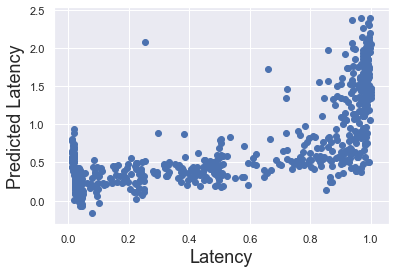

In [561]:
plt.scatter(y_test, y_test_pred)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

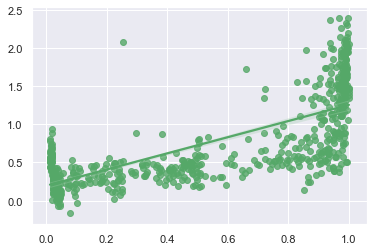

In [562]:
ax = sns.regplot(x=y_test, y=y_test_pred, color='g')

In [563]:
perf = pd.DataFrame(y_test_pred, columns=['prediction'])
perf['target'] = y_test
perf.head()

,prediction,target
0,0.2202,0.0226
1,0.2982,0.0226
2,0.2586,0.0226
3,0.2142,0.0226
4,0.2285,0.0226


In [564]:
# testing mean_absolute_percentage_error
perf['residual'] = perf['prediction'] - perf['target']
perf['difference%'] = np.absolute(perf['residual'] * 100 / perf['target'])
perf

,prediction,target,residual,difference%
0,0.2202,0.0226,0.1976,873.7429
1,0.2982,0.0226,0.2756,"1,218.8445"
2,0.2586,0.0226,0.2359,"1,043.5338"
3,0.2142,0.0226,0.1916,847.5407
4,0.2285,0.0226,0.2059,910.5934
...,...,...,...,...
672,1.5190,0.9877,0.5314,53.8011
673,1.5423,0.9877,0.5546,56.1567
674,1.7286,0.9856,0.7430,75.3864
675,1.7295,0.9887,0.7408,74.9287


In [565]:
perf.describe()

,prediction,target,residual,difference%
count,677.0000,677.0000,677.0000,677.0000
mean,0.7305,0.5044,0.2261,504.1514
std,0.5779,0.4055,0.3860,"1,017.5155"
min,-0.1683,0.0134,-0.7164,0.1528
25%,0.3011,0.0380,-0.0257,31.0118
50%,0.5098,0.4841,0.1902,62.7670
75%,1.1095,0.9476,0.4792,361.8581
max,2.4004,1.0000,1.8230,"5,988.8236"


In [566]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.4f' % x)
perf.sort_values(by = ['difference%'])

,prediction,target,residual,difference%
315,0.4587,0.4594,-0.0007,0.1528
335,0.2511,0.2497,0.0014,0.5550
240,0.4436,0.4471,-0.0035,0.7746
255,0.3219,0.3248,-0.0029,0.8975
319,0.4705,0.4656,0.0049,1.0585
386,0.9688,0.9825,-0.0137,1.3955
313,0.3775,0.3720,0.0054,1.4640
237,0.4131,0.4070,0.0062,1.5117
191,0.3215,0.3268,-0.0053,1.6176
262,0.6107,0.6208,-0.0101,1.6241


# *** Prediction Accuracy

In [567]:
r2_test = metrics.r2_score(y_test, y_test_pred)
print('R2 (testing) = {}'.format(r2_test))

# also: R-Squared could obtain with
# pline.score(x_test, y_test)

R2 (testing) = -0.21772528839158767


In [568]:
print(np.sqrt(mean_squared_error(y_test,y_test_pred)))

0.4471339478673362
